# Anwendung modell-agnostischer XAI-Verfahren auf synthetischen Strukturdaten

Der Code und die Plots in diesem Notebook sind im Rahmen meines Bachelorprojektes entstanden.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.stats import norm
from numpy import sin, cos, tanh, exp, log, log2
from IPython.display import display, clear_output
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, classification_report, confusion_matrix

In [33]:
plt.style.use('ggplot')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 14,
})

In [17]:
def metrics(y_true, y_pred):
    """Function that displays the confusion matrix and the accuracy score of a prediction to the true y values"""
    display(pd.DataFrame(confusion_matrix(y_true, y_pred)))
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.2f}")

In [18]:
def weighted_choice(sequence, weights, size):
    """
    Function to easily generate weighted random numbers.

    Parameter
    ---------
    sequence : array_like
        List of numbers of length n that will be chosen randomly.
    weights : array_like
        List of length n containing int values as weights for the random choice.
    size :  int or tuple of ints
        Shape of the outcoming array.
        
    Returns
    -------
    out: ndarray
        An array object of weighted random numbers.
    """
    weighted_sequence = [[i]*w for i, w in zip(sequence, weights)]
    return np.random.choice([item for sublist in weighted_sequence for item in sublist], size)

## Datenmodell

Zum Testen der XAI-Verfahren wird folgende Anforderung an den Datensatz definiert:
- Einfache ML-Modelle müssen eine schwache Performance aufweisen
- Komplexe ML-Modelle müssen gute bis sehr gute Ergebnisse auf die vorliegenden Daten erzielen

Zu diesem Zweck werden im ersten Schritt die Daten __synthetisiert__. Dies erspart die Suche nach einem geeigneten Datensatz und bringt zusätzlich den Vorteil mit, dass alle Wirkzusammenhänge schon im Vornherein bekannt sind. Somit fällt eine explorative Analyse der Daten ebenfalls weg.

Der Datensatz betrachtet 10 Merkmale. Die Merkmale 1...4 stellen kategorische Merkmale dar, welche zufällig gewichtet sind. Für die restlichen Merkmale wurde zur Vereinfachung eine Standardnormalverteilung angenommen.

In [19]:
np.random.seed(42)

n = 100000 # number of instances in the dataset

# categorical features
X = pd.DataFrame(np.array([
    weighted_choice(
        [ 0,  1, 2,  3,  4], # values
        [15, 20, 5, 40, 20], # weights
        n),
    
    weighted_choice(
        [ 0,  1,  2], # values
        [60, 30, 10], # weights
        n),
    
    weighted_choice(
        [ 0,  1, 2,  3,  4,  5, 6], # values
        [10, 46, 5, 15, 10, 12, 2], # weights
        n),
    
    weighted_choice(
        [ 0,  1, 2,  3], # values
        [37, 18, 5, 40], # weights
        n),
]).T)

# numerical features
X[[4, 5, 6, 7, 8, 9]] = np.random.normal(0, 1, (n, 6))

In [20]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
0,100000.0,2.298080,1.386264,0.000000,1.000000,3.000000,3.000000,4.000000
1,100000.0,0.500760,0.670063,0.000000,0.000000,0.000000,1.000000,2.000000
2,100000.0,2.128910,1.672346,0.000000,1.000000,1.000000,3.000000,6.000000
3,100000.0,1.478380,1.336769,0.000000,0.000000,1.000000,3.000000,3.000000
4,100000.0,-0.000696,0.999483,-4.404214,-0.677095,-0.003063,0.677155,4.526784
5,100000.0,-0.002472,1.003053,-4.413886,-0.677677,0.000039,0.672136,4.311586
6,100000.0,0.000015,1.001587,-4.829436,-0.672627,0.002556,0.675558,4.153257
7,100000.0,-0.005498,1.001836,-4.251364,-0.684025,-0.006024,0.673308,4.678949
8,100000.0,-0.003124,0.997704,-4.283087,-0.677267,0.000150,0.669791,4.019419
9,100000.0,0.006893,1.000226,-4.142430,-0.672549,0.005894,0.679175,4.301848


Im nächsten Schritt wird für jedes Merkmal eine Funktion definiert, welche Einfluss auf die Zielvariable nimmt.

Um die an den Datensatz geforderten Anforderungen zu erfüllen, muss darauf geachten werden, dass der Datensatz __möglichst nicht linear__ ist. Aus diesem Grund werden die Wirkzusammenhänge der einzelnen Features mithilfe von __trigonometrischen Funktionen erzeugt__:

In [21]:
g = lambda x: 0.05 * x**2 + 0.1

functions = [
    lambda x: 0.18 * sin(1 * x),
    lambda x: 0.09 * sin(2 * x - 1),
    lambda x: 0.12 * sin(3 * x),
    lambda x: 0.18 * sin(1 * x + 2),
    lambda x: -cos(3*x) * g(x),
    lambda x: sin(10*x) * g(x),
    lambda x: 0.01 * sin(13*x + 4),
    lambda x: sin(6*x + 2) * g(x),
    lambda x: cos(20*x + 0.123) * g(x),
    lambda x: cos((x+5)**2) * g(x),
]

In [25]:
# this helps to identify the column types
feature_types = ['categorical'] * 4 + ['numerical'] * 6

Zur besseren Übersicht werden die Wirkzusammenhänge zwischen den Merkmalen und der Zielvariablen geplottet:

In [26]:
# calculate the histograms once for the following plots
cat_value_counts = [
    X[0].value_counts().sort_index(),
    X[1].value_counts().sort_index(),
    X[2].value_counts().sort_index(),
    X[3].value_counts().sort_index(),
]

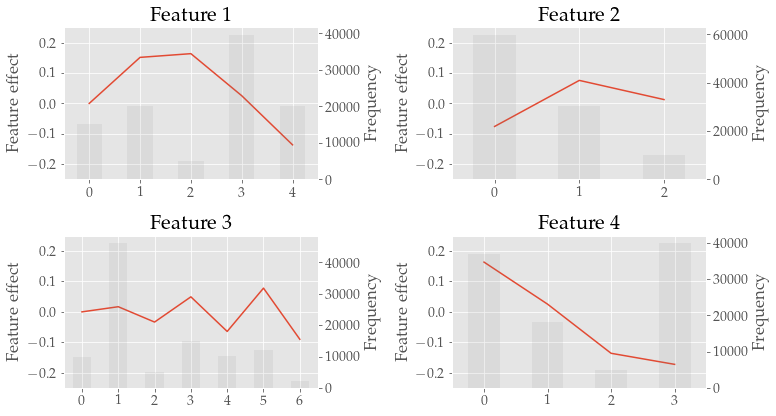

In [41]:
fig, axs = plt.subplots(2, 2, figsize=(11, 6))

for i in range(2):
    for j in range(2):
        idx = i * 2 + j
        ax = axs[i, j]
        
        x = cat_value_counts[idx].index
        ax.plot(x, functions[idx](x))
        ax.set_ylabel('Feature effect')
        ax.set_ylim(-0.25, 0.25)
        ax.set_title(f"Feature {idx+1}")
        
        twin = ax.twinx()
        cat_value_counts[idx].plot.bar(ax=twin, color='grey', alpha=0.1)
        twin.set_ylabel('Frequency')
        twin.grid(False)
        
plt.tight_layout()
plt.show()

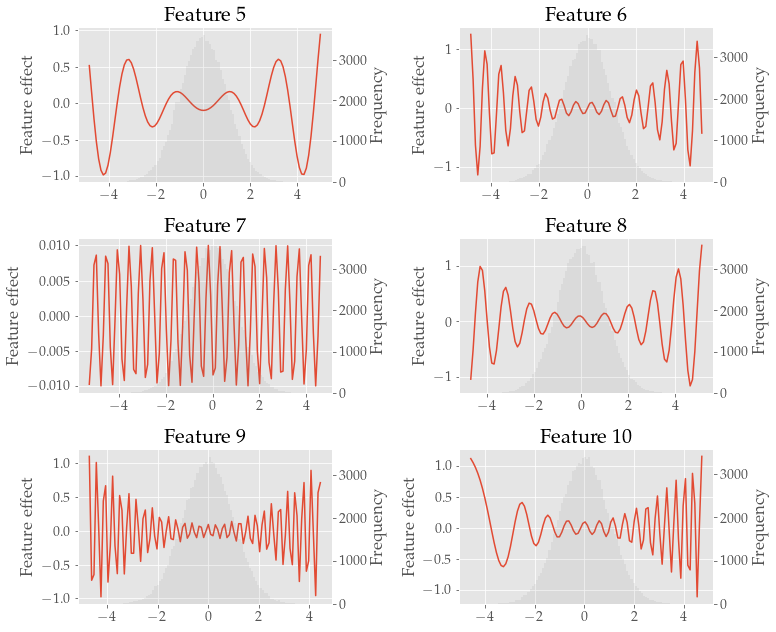

In [45]:
fig, axs = plt.subplots(3, 2, figsize=(11, 9))

for i in range(3):
    for j in range(2):
        idx = i * 2 + j + 4
        ax = axs[i, j]
        twin = ax.twinx()
        X[idx].plot.hist(ax=twin, color='grey', alpha=0.1, bins=100)
        twin.set_ylabel('Frequency')
        ax.set_title(f"Feature {idx+1}")
        
        x = np.linspace(*twin.get_xlim(), 100)
        ax.plot(x, functions[idx](x))
        ax.set_ylabel('Feature effect')
#         ax.set_ylim(-0.25, 0.25)
        twin.grid(False)
        
plt.tight_layout()
plt.show()

Die aus den einzelnen Funktionen $f_i$ mit $i=0...9$ resultierende Funktion $f$ wird in die SciKit-Learn API gewrappt, damit diese auch mit den XAI-Verfahren analysiert werden kann:

In [46]:
from sklearn.base import BaseEstimator 
from sklearn.base import RegressorMixin


class FRegressor(BaseEstimator, RegressorMixin):

    def __init__(self, **model_hyper_parameters):
        self.params_ = 1 # must not be None to signalize that the estimator was already fitted
        super().__init__()

    def fit(self, X, Y=None):
        return self

    def predict(self, X):
        if type(X) == pd.core.frame.DataFrame:
            X = X.to_numpy()
        y = np.full(len(X), 0.5)

        for i, f in enumerate(functions):
            y += f(X[:, i])

        return y
    
f = FRegressor()

In [47]:
y = pd.Series(f.predict(X))
    
y = (y > 0.5).astype(int)

counts = y.value_counts()
a, b = counts[0], counts[1]
print(f"0: {100 *a / (a + b):.2f} %")
print(f"1: {100 *b / (a + b):.2f} %")

0: 49.18 %
1: 50.82 %


<AxesSubplot:ylabel='Binary Classifications'>

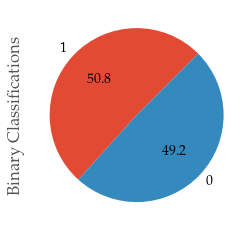

In [48]:
counts.plot.pie(label='Binary Classifications', autopct="%.1f%%", startangle=45)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
metrics(y_test, f.predict(X_test) > 0.5)

,0,1
0,9904,0
1,0,10096


Accuracy:  1.00


## Feature Importance im Datensatz

Da die Wirkzusammenhänge der einzelnen Merkmale im Datensatz durch die jeweiligen Funktionen $f_i$ bekannt sind, lässt sich auch die Feature Importance jedes Merkmals berechnen. Dazu wird betrachtet, wie sehr ein Merkmal den Zielwert $y$ im Mittel beeinflusst.

Für kategorische Merkmale berechnet sich der durchschnittliche Einfluss über:

$$f_i(\xi) = \sum \limits_{x \in \mathbb{D}_{f_i}} \mathbb{P}_i(x)\cdot |f_i(x)|$$

Für numerische Merkmale wird der gewichtete Mittelwertsatz aus der Integralrechnung verwendet:

$$f_i(\xi) = \int f_i(x) d \mathbb{P}_i(x)$$

$\mathbb{P}_i(x)$ entspricht hierbei der Wahrscheinlichkeit für das Eintreten eines Wertes $x$ und bildet somit die Gewichtung in Abhängigkeit von $x$. Für numerische Merkmale ist dies die Standardnormalverteilung:

$$\mathbb{P}(x) = \frac{1}{\sigma \sqrt{2\pi}} \cdot e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2}$$

Mit Erwartungswert $\mu = 0$ und Standardabweichung $\sigma = 1$

Die Feature Importances werden im nächsten Schritt statistisch ermittelt:

In [52]:
feature_importances = pd.Series(np.arange(10)).apply(lambda i: functions[i](X[i]).abs().mean())

In [53]:
feature_importances[:4]

0    0.076091
1    0.069461
2    0.034470
3    0.140780
dtype: float64

In [54]:
# Importance of feature 0
np.abs(functions[0]([0, 1, 2, 3, 4])).dot([0.15, 0.20, 0.05, 0.40, 0.20])

0.07588216270591126

In [55]:
# Importance of feature 3
np.abs(functions[3](np.array([0, 1, 2, 3]))).dot([0.37, 0.18, 0.05, 0.40])

0.14098526712124743

In [56]:
feature_importances.index += 1
feature_importances /= feature_importances.sum()
feature_importances.sum()

1.0

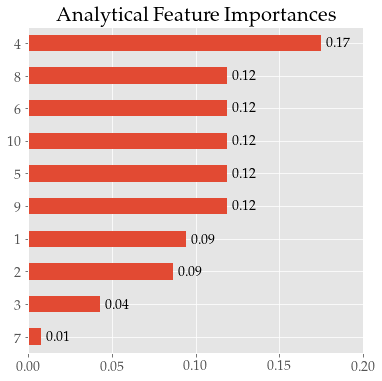

In [60]:
fig, ax = plt.subplots(figsize=(6, 6))
sorted_fi = feature_importances.sort_values()
sorted_fi.plot.barh(ax=ax)#, color='tab:red')
ax.set_xlim(0, 0.20)

for i, rect in enumerate(ax.patches):
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    
    label = "{:.2f}".format(sorted_fi.iloc[i])
    
    ax.annotate(
        label,
        (x_value, y_value),
        xytext=(5, -8),
        textcoords="offset points",
        va='bottom',
        ha='left'
    )
    
ax.set_title('Analytical Feature Importances')
plt.show()

Zur besseren Vergleichbarkeit werden die Feature Importances normalisiert, sodass sie in Summe 1 ergeben.

### Partial Dependence Plots für $f$

In [62]:
from sklearn.inspection import partial_dependence

f_pdps = [partial_dependence(f, X_test, [i]) for i in range(10)]

C:\Users\Renke\anaconda3\envs\ml\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


In [86]:
def plot_partial_dependence(idx, ax, pdps):
    pdp, axes = pdps[idx]
    twin = ax.twinx()
    
    if feature_types[idx] == 'categorical':
        ax.set_ylim(-0.3, 0.3)
        pd.DataFrame([pdp[0] - 0.5, functions[idx](axes[0])], index=['pdp', 'f']).T.plot.bar(ax=ax)        
        cat_value_counts[idx].plot.bar(ax=twin, alpha=0.1, color='grey')
    else:
        ax.plot(axes[0], pdp[0] - 0.5)
        xlim = ax.get_xlim()        
        x = np.linspace(*xlim, 100)
        ax.plot(x, functions[idx](x))
        ax.legend(['pdp', 'f'], loc=1)
        X_test.iloc[:, idx].plot.hist(ax=twin, alpha=0.1, color='grey', bins=100)
        twin.set_xlim(xlim)
        a, b = ax.get_ylim()
        ax.set_ylim(1.5*a, 1.5*b)
        
    ax.set_title(f'Feature {idx + 1}')
    ax.set_ylabel('Feature effect')
    twin.set_ylabel('Frequency')
    twin.grid(False)

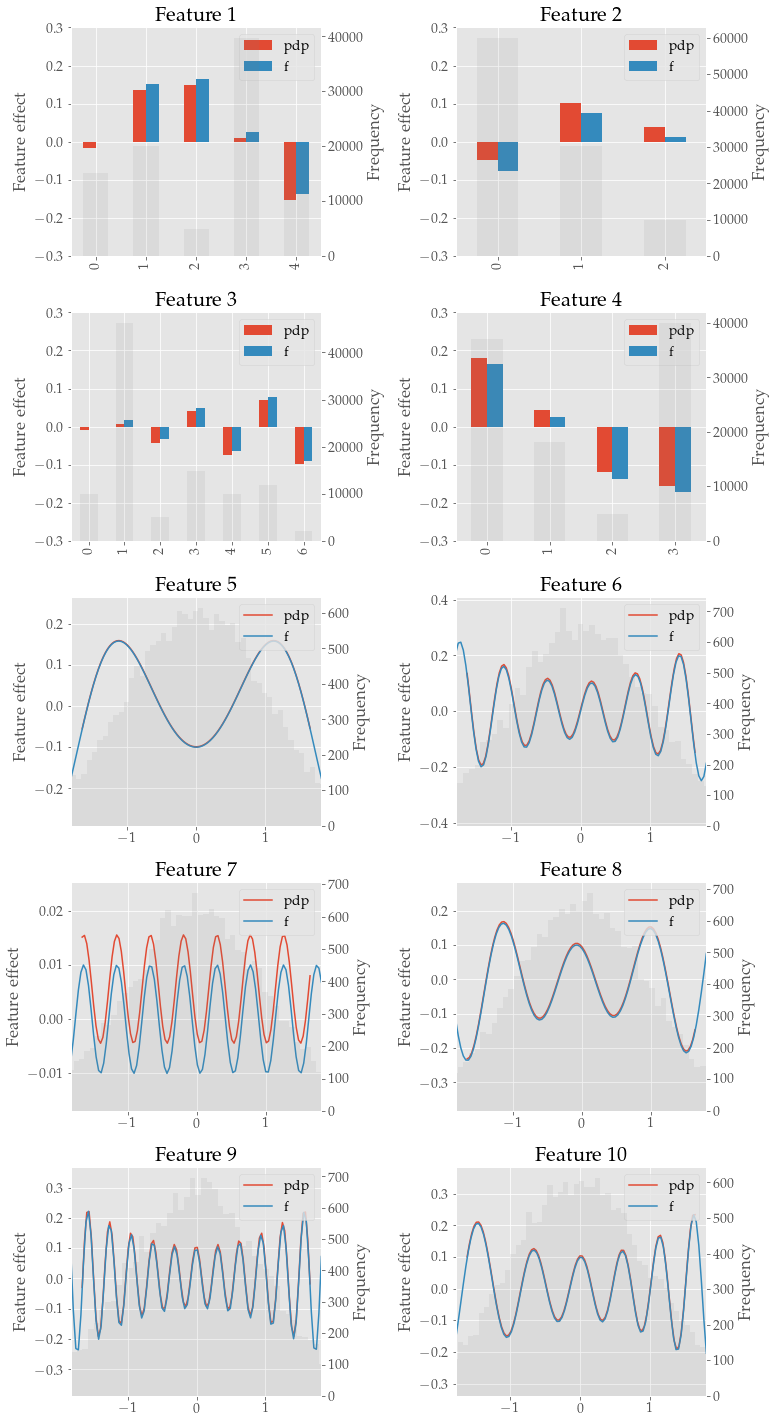

In [87]:
fig, axs = plt.subplots(5, 2, figsize=(11, 20))

for i in range(5):
    for j in range(2):
        plot_partial_dependence(i * 2 + j, axs[i, j], f_pdps)
        
plt.tight_layout()

## SHAP für $f$

In [89]:
import shap
shap.initjs()

In [90]:
med = X.median().values.reshape((1, X.shape[1]))

In [91]:
f_explainer = shap.Explainer(f.predict, med)
f_values = f_explainer(X_test[:5000])

In [159]:
def plot_function_with_hist(idx, ax):
    twin = ax.twinx()
    twin.set_ylabel('Frequency')
    if feature_types[idx] == 'categorical':
        x = X_test[idx].value_counts().sort_index().index
        ax.set_ylim(-0.4, 0.4)
        pd.Series(functions[idx](x), index=x).plot(ax=ax, alpha=0.5)
        cat_value_counts[idx].plot.bar(ax=twin, color='grey', alpha=0.1)
    else:
        x = np.linspace(*ax.get_xlim(), 100)
        ax.plot(x, functions[idx](x))
        X_test[idx].plot.hist(ax=twin, color='grey', alpha=0.1, bins=100)
        a, b = ax.get_ylim()
        ax.set_ylim(1.5*a, 1.5*b)
    ax.set_xlabel("")
    twin.grid(False)

In [160]:
def shap_pdp(idx, ax, values, df=X_test[:5000]):
    shap.dependence_plot(idx, values, df, interaction_index=None, ax=ax, show=False, alpha=0.4)
    plot_function_with_hist(idx, ax)
    ax.legend([f'F{idx + 1}', 'SHAP'], loc=1)
    ax.set_title(f'Feature {idx + 1}')
    ax.set_ylabel('Feature effect')

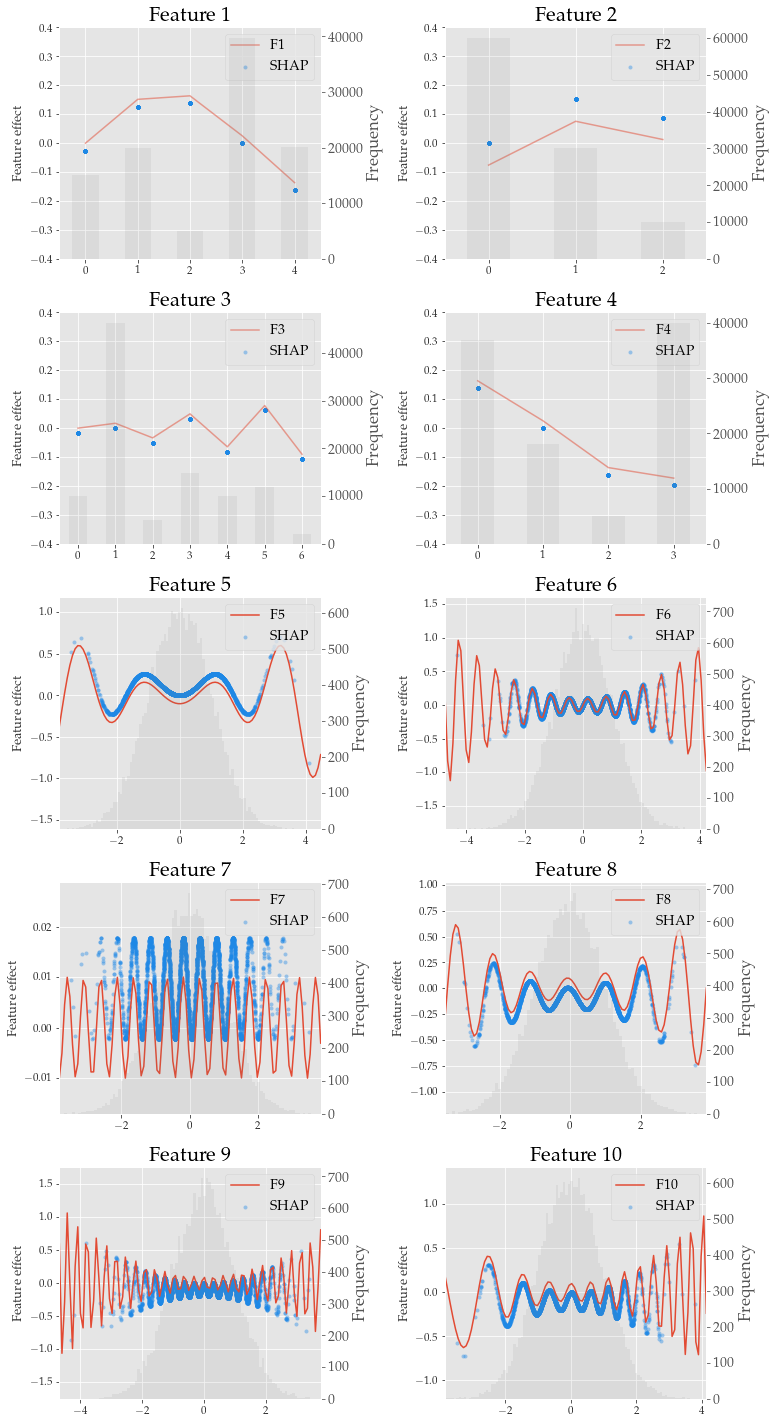

In [161]:
fig, axs = plt.subplots(5, 2, figsize=(11, 20))

for i in range(5):
    for j in range(2):
        shap_pdp(i * 2 + j, axs[i, j], f_values.values)
        
plt.tight_layout()

In [108]:
f_shap_global_importances = pd.Series(np.abs(f_values.values).sum(axis=0) / 5000).sort_values()
f_shap_global_importances /= f_shap_global_importances.sum()
f_shap_global_importances.index += 1

## LIME für $f$

In [109]:
import lime
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    X.to_numpy(),
    feature_names=X.columns.to_list(), 
    class_names=["Kreditausfall"],
    categorical_features=[0, 1, 2, 3],
    verbose=False,
    mode='regression',
)

In [110]:
def lime_explain(df, explainer, f):
    explanations = pd.DataFrame(columns=list(df.columns) + ['intercept', 'score'])
    m = len(df.columns)
    n = len(df)
    
    for i in range(n):
        clear_output(wait=True)
        print("{:.2f} %".format(100 * i / n))
        exp = explainer.explain_instance(df.iloc[i], f, num_features=m)
        series = pd.Series(dict(exp.as_map()[1] + [('intercept', exp.intercept[1]), ('score', exp.score)]))
        explanations.loc[df.iloc[i].name] = series
        
    clear_output(wait=True)
    print("100.00 %")
    return explanations

In [111]:
path = Path('f_lime_explanations.csv')

if path.is_file():
    f_lime_explanations = pd.read_csv(path, index_col=0)
    f_lime_explanations = f_lime_explanations.rename(columns={c: int(c) for c in f_lime_explanations.columns[:10]})
else:
    f_lime_explanations = lime_explain(X_test[:1000], explainer, f.predict)
    f_lime_explanations.to_csv(path)

In [124]:
def lime_pdp(idx, ax, explanations, df=X_test[:1000]):    
    x = df[idx]
    y = explanations[idx]
    ax.scatter(x, y, alpha=0.2, color='tab:blue')
    plot_function_with_hist(idx, ax)
    
    ax.legend([f'F{idx + 1}', 'LIME'], loc=1)
    ax.set_title(f'Feature {idx + 1}')
    ax.set_ylabel('Feature effect')

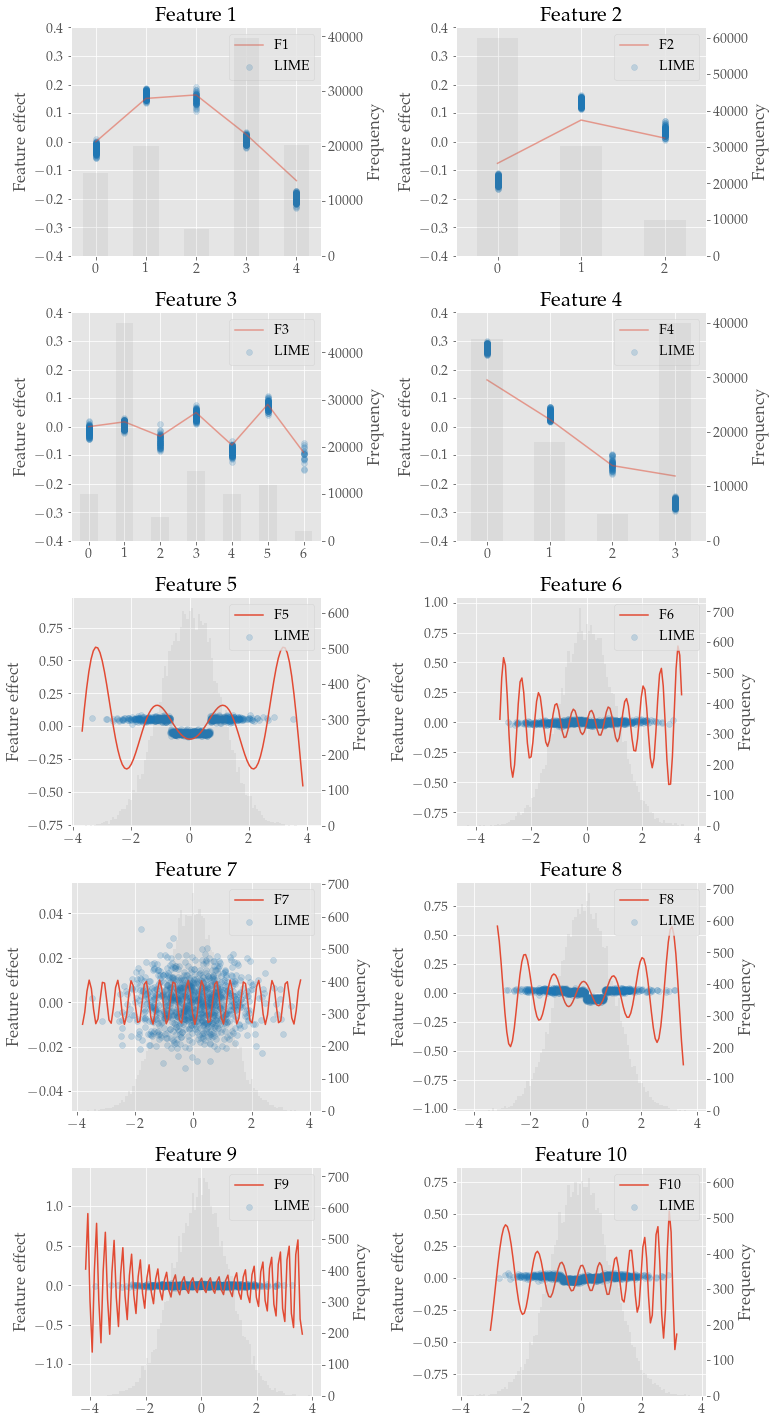

In [125]:
fig, axs = plt.subplots(5, 2, figsize=(11, 20))

for i in range(5):
    for j in range(2):
        lime_pdp(i * 2 + j, axs[i, j], f_lime_explanations, X_test[:1000])
        
plt.tight_layout()

In [113]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)

In [114]:
pd.DataFrame([  
    pd.Series(f_values.values[:, 0][f_values.data[:, 0] == 0]).describe(),
    f_lime_explanations[0][X_test[:1000][0] == 0].describe()  
], index=['SHAP', 'LIME']).T

,SHAP,LIME
count,747.000000,145.000000
mean,-0.025402,-0.024207
std,0.000000,0.012635
min,-0.025402,-0.056403
25%,-0.025402,-0.031935
50%,-0.025402,-0.023674
75%,-0.025402,-0.016253
max,-0.025402,0.009404


In [115]:
m = 0

values = X_test[:1000][m].unique()

desc = pd.DataFrame()

for v in values:
    desc = desc.append(f_lime_explanations[m][X_test[:1000][m] == v].describe())

In [116]:
desc.index=values

In [117]:
desc['max'] - desc['min']

4   0.058974
3   0.053245
2   0.082877
1   0.051705
0   0.065807
dtype: float64

In [126]:
f_lime_global_importances = f_lime_explanations.iloc[:, :-2].abs().T
f_lime_global_importances = (f_lime_global_importances / f_lime_global_importances.sum()).mean(axis=1).sort_values()
f_lime_global_importances.index += 1

## Feature Importances im Vergleich (Analytisch - SHAP - LIME)

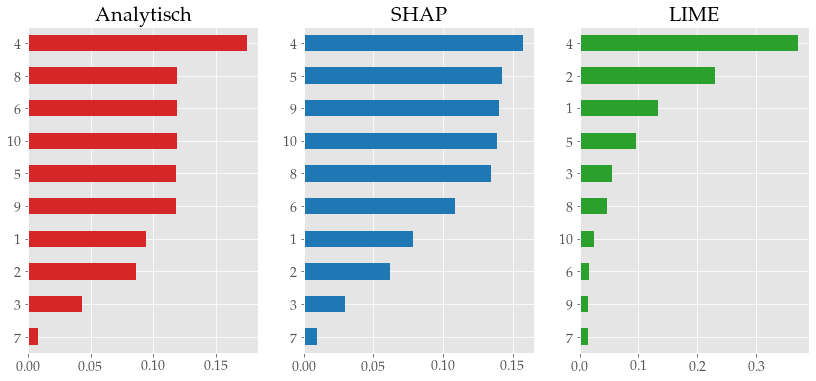

In [129]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

feature_importances.sort_values().plot.barh(ax=axs[0], color='tab:red')
axs[0].set_title('Analytisch')
f_shap_global_importances.plot.barh(ax=axs[1], color='tab:blue')
axs[1].set_title('SHAP')
f_lime_global_importances.plot.barh(ax=axs[2], color='tab:green')
axs[2].set_title('LIME')
plt.show()

Man kann erkennen, dass die von SHAP ermittelten Feature Importances sehr ähnlich zu denen sind, die analytisch ermittelt wurden. Die Rangfolgen beider Verfahren sind in den mittleren Rängen sehr unterschiedlich. Dies liegt vor allem daran, dass die Impotances zielich ausgeglichen sind. LIME

### Modelle

### Logistische Regression

Bei der logistischen Regression handelt es sich um ein einfaches interpretierbares Modell, mit dem sich linear trennbare Daten schnell und einfach klassifizieren lassen.

In [130]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
metrics(y_test, lr.predict(X_test))

,0,1
0,6808,3096
1,2941,7155


Accuracy:  0.70


### K-Nearest Neighbors

In [131]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier().fit(X_train, y_train)
metrics(y_test, knn.predict(X_test))

,0,1
0,6710,3194
1,2951,7145


Accuracy:  0.69


### Decision Tree

Dieses Modell spannt einen einzelnen Entscheidungsbaum auf und gehört somit auch noch zu den einfacheren Verfahren im Machine Learning. Solange der Baum nicht zu groß ist, ist er noch interpretierbar. 

In [132]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier().fit(X_train, y_train)
metrics(y_test, dt.predict(X_test))

,0,1
0,7021,2883
1,2890,7206


Accuracy:  0.71


### Random Forest

Der Random Forest Classifier bildet einen ganzen "Wald" von unabhängigen Entscheidungsbäumen. Durch Mehrheitsentscheide dieser Entscheidungsbäume entstehen solidere Ergebnisse. Das Modell gehört damit zu den komplexeren ML-Verfahren.

In [133]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier().fit(X_train, y_train)
metrics(y_test, rf.predict(X_test))

,0,1
0,7893,2011
1,2035,8061


Accuracy:  0.80


### XGBoost

XGBoost ist ein baumbasiertes Modell, welches sich das Verfahren des Gradient Boosting zu Nutze macht, um sehr gute Performances zu erreichen.

In [134]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    objective='reg:logistic',
    use_label_encoder=False
).fit(X_train, y_train)
metrics(y_test, xgb.predict(X_test))

,0,1
0,9158,746
1,785,9311


Accuracy:  0.92


In [135]:
precision_score(y_test, xgb.predict(X_test))

0.9258228099830963

In [136]:
xgb_importances = pd.Series(xgb.feature_importances_)
xgb_importances /= xgb_importances.sum()
xgb_importances.index += 1

## XAI auf XGBoost

### PDP

In [137]:
xgb_pdps = [partial_dependence(xgb, X_test, [i]) for i in range(10)]

A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.


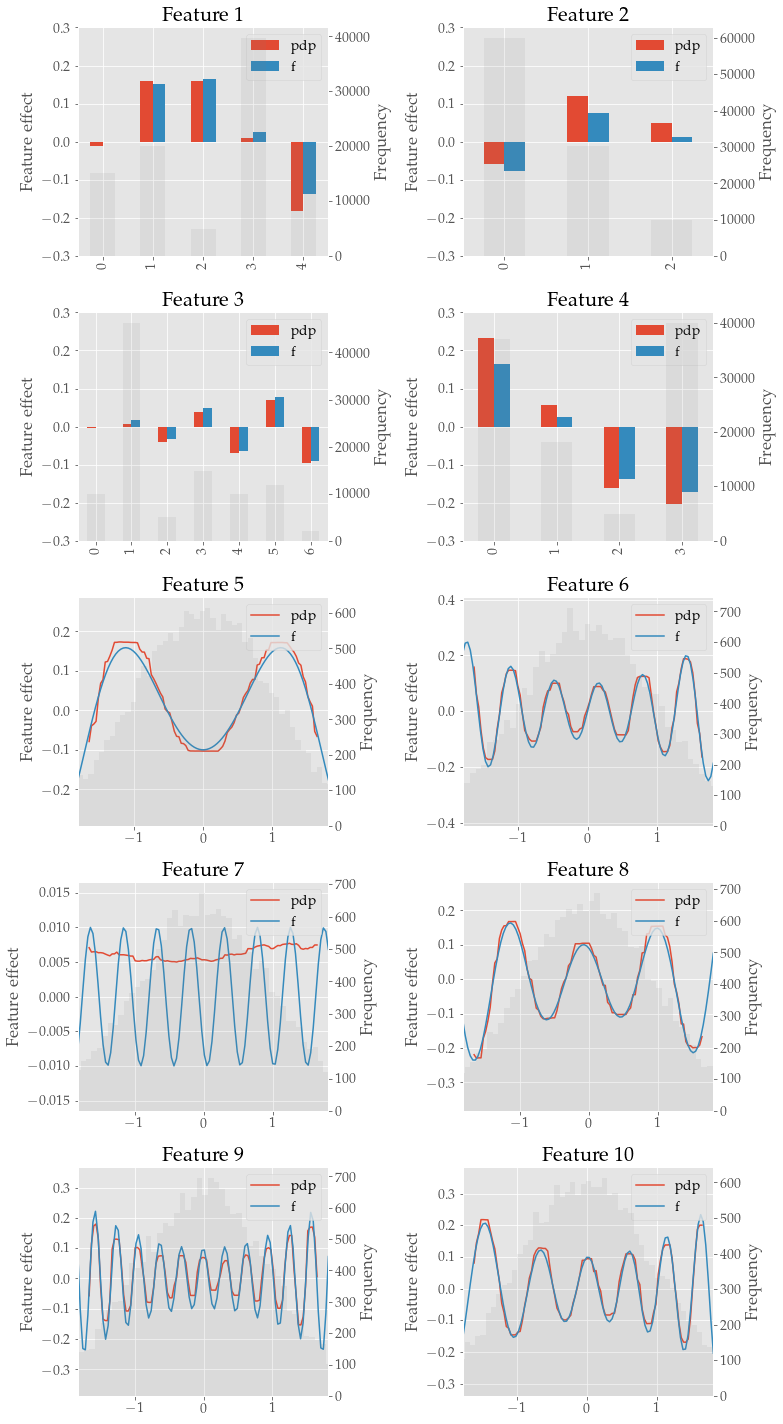

In [139]:
fig, axs = plt.subplots(5, 2, figsize=(11, 20))

for i in range(5):
    for j in range(2):
        plot_partial_dependence(i * 2 + j, axs[i, j], xgb_pdps)
        
plt.tight_layout()

In [140]:
xgb_pdps[6][0].max() - xgb_pdps[6][0].min()

0.0027055144

### SHAP

In [141]:
f_xgb = lambda x: xgb.predict_proba(x)[:, 1]

xgb_explainer = shap.Explainer(f_xgb, med)
xgb_values = xgb_explainer(X_test[:5000])

Exact explainer: 5001it [00:45, 87.47it/s]                                                                             


In [142]:
colors = np.abs(f_xgb(X_test[:5000]) - 0.5) * 2

In [143]:
xgb_values_df = pd.DataFrame(xgb_values.values)

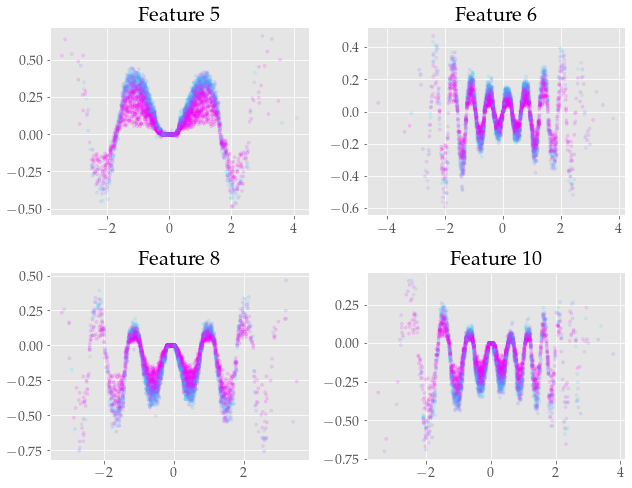

In [167]:
fig, axs = plt.subplots(2, 2, figsize=(9, 7))

for idx, v in enumerate([4, 5, 7, 9]):
    ax = axs[idx // 2, idx % 2]
    ax.scatter(X_test[:5000][v], xgb_values_df[v], alpha=0.15, cmap='cool', c=colors, s=10)
    ax.set_title(f"Feature {v+1}")

plt.tight_layout()
plt.show()

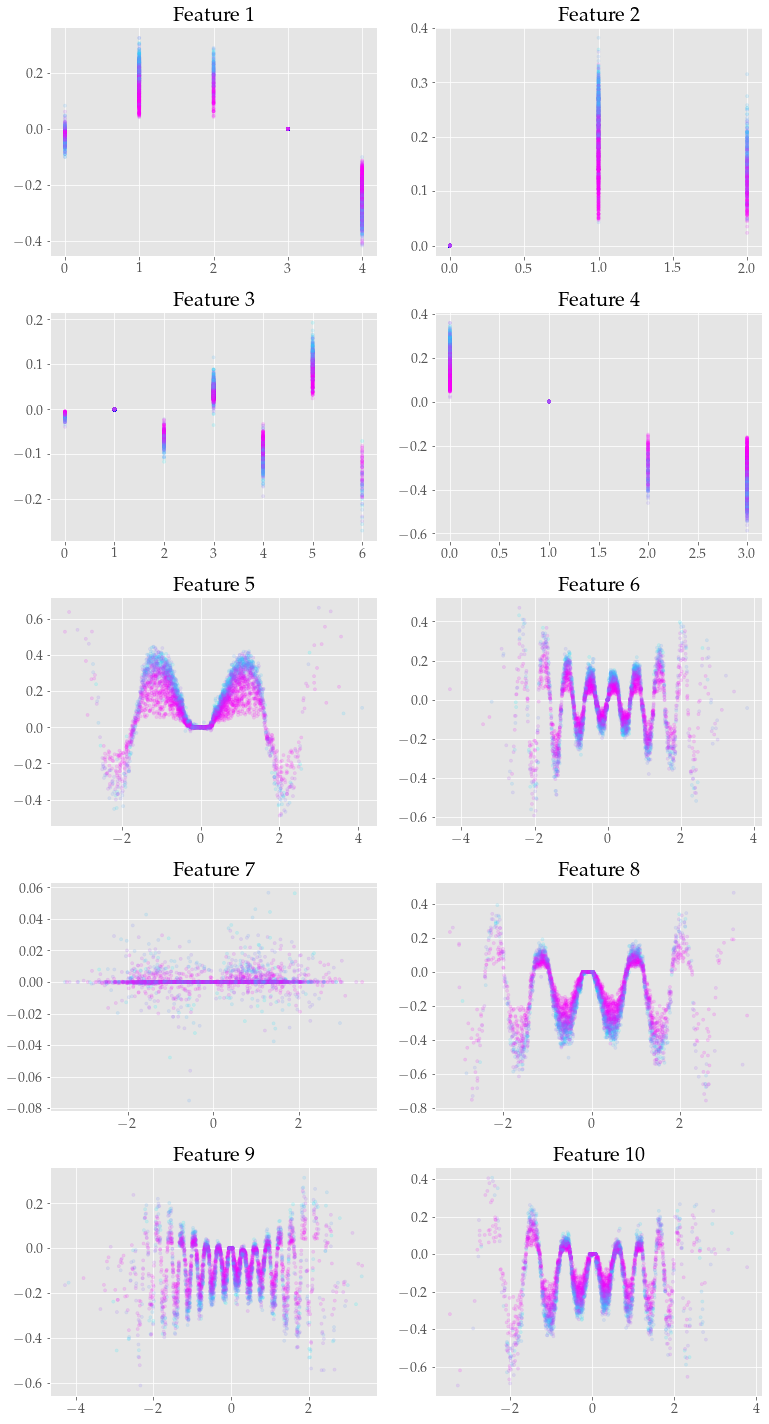

In [147]:
fig, axs = plt.subplots(5, 2, figsize=(11, 20))

for i in range(5):
    for j in range(2):
        idx = i * 2 + j
        ax = axs[i, j]
        ax.scatter(X_test[:5000][idx], xgb_values_df[idx], alpha=0.15, cmap='cool', c=colors, s=10)
        ax.set_title(f"Feature {idx+1}")
#         plot_function_with_hist(idx, ax)

plt.tight_layout()
plt.show()

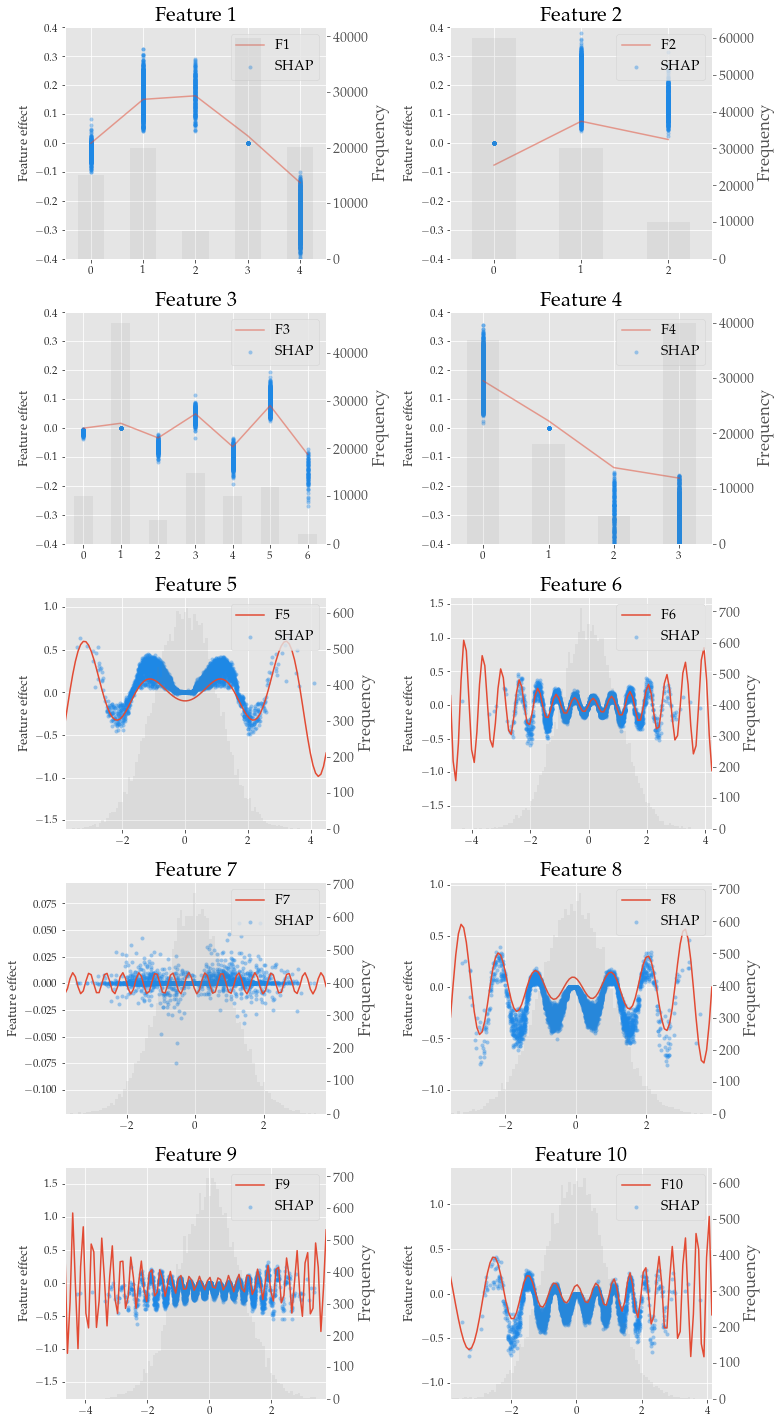

In [162]:
fig, axs = plt.subplots(5, 2, figsize=(11, 20))

for i in range(5):
    for j in range(2):
        shap_pdp(i * 2 + j, axs[i, j], xgb_values.values)
        
plt.tight_layout()

In [149]:
xgb_shap_importances = pd.Series(np.abs(xgb_values.values).sum(axis=0) / 5000)
xgb_shap_importances /= xgb_shap_importances.sum()
xgb_shap_importances.index += 1

### LIME

In [151]:
path = Path('xgb_lime_explanations.csv')

if path.is_file():
    xgb_lime_explanations = pd.read_csv(path, index_col=0)
    xgb_lime_explanations = xgb_lime_explanations.rename(columns={c: int(c) for c in xgb_lime_explanations.columns[:10]})
else:
    xgb_lime_explanations = lime_explain(X_test[:1000], explainer, f_xgb)
    xgb_lime_explanations.to_csv(path)

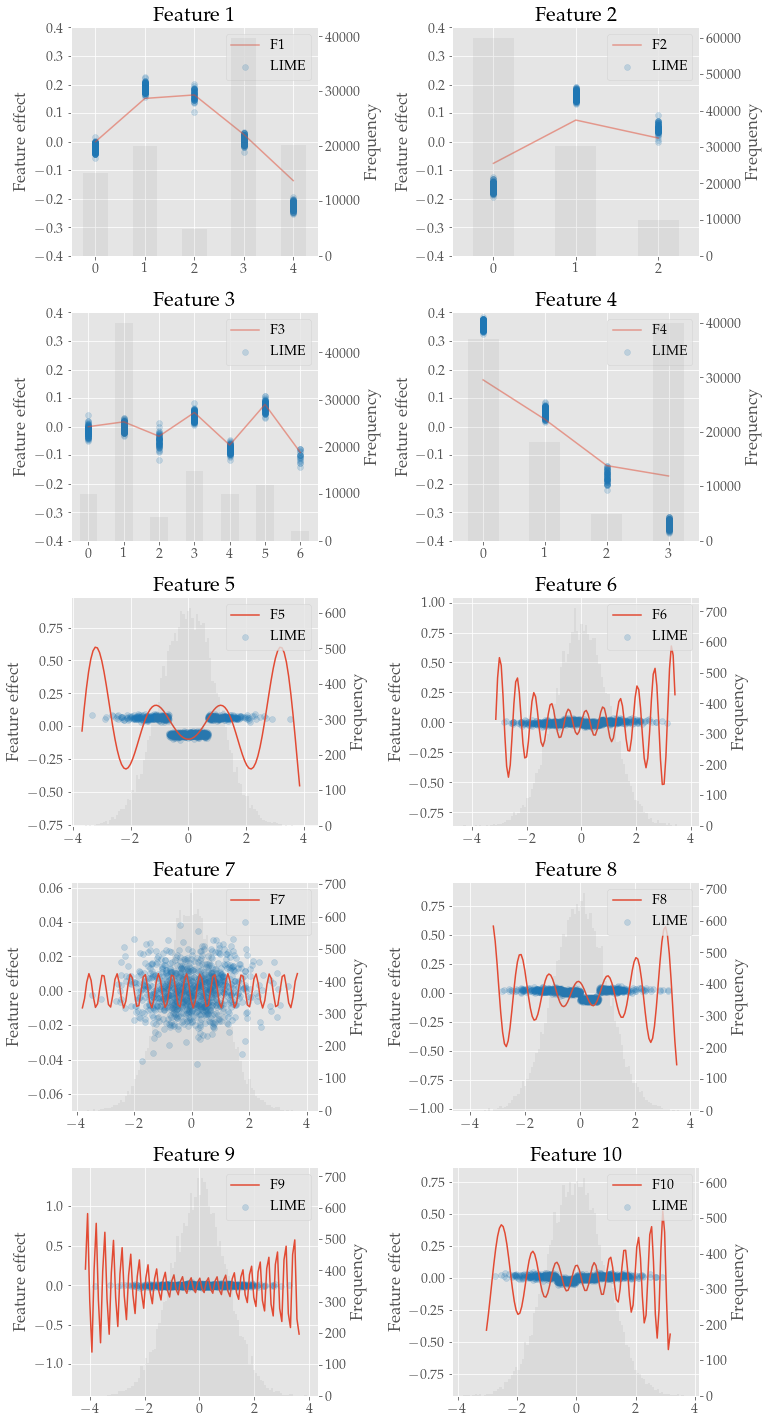

In [152]:
fig, axs = plt.subplots(5, 2, figsize=(11, 20))

for i in range(5):
    for j in range(2):
        lime_pdp(i * 2 + j, axs[i, j], xgb_lime_explanations)
        
plt.tight_layout()

In [153]:
xgb_lime_importances = xgb_lime_explanations.iloc[:, :-2].abs().T
xgb_lime_importances = (xgb_lime_importances / xgb_lime_importances.sum()).mean(axis=1).sort_values()
xgb_lime_importances.index += 1

In [154]:
xgb_lime_explanations['score'].describe()

count   1000.000000
mean       0.230813
std        0.090125
min        0.011297
25%        0.222229
50%        0.261187
75%        0.294255
max        0.352558
Name: score, dtype: float64

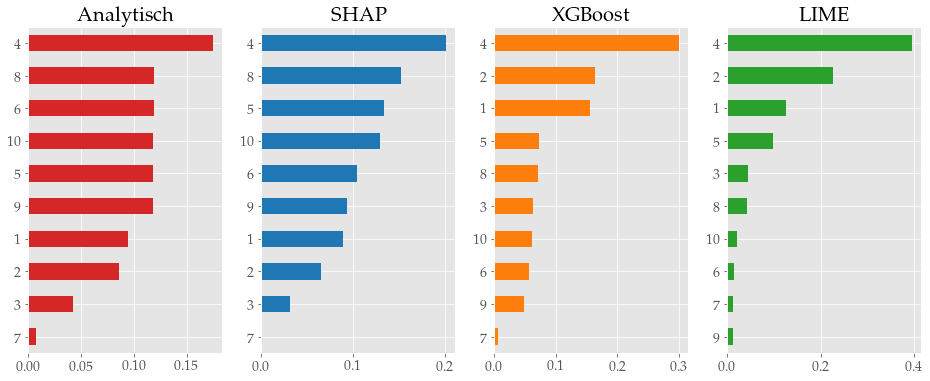

In [155]:
fig, axs = plt.subplots(1, 4, figsize=(16, 6))

feature_importances.sort_values().plot.barh(ax=axs[0], color='tab:red')
axs[0].set_title('Analytisch')
xgb_shap_importances.sort_values().plot.barh(ax=axs[1], color='tab:blue')
axs[1].set_title('SHAP')
xgb_importances.sort_values().plot.barh(ax=axs[2], color='tab:orange')
axs[2].set_title('XGBoost')
xgb_lime_importances.plot.barh(ax=axs[3], color='tab:green')
axs[3].set_title('LIME')
plt.show()